# Income Prediction

Problem Statement :: Task is to determine whether a person makes over $50K a year or not i.e., there are only 2 categories  ($50K, <=$50K per year) on which each employee will be classified.  
Technical Statement :: Binary Classification for Income as Target

In [1]:
## Importing all the necessary libraries
# General Modules
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 
from ydata_profiling import ProfileReport
import pycountry_convert as pc

%matplotlib inline

# ML Modules
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import mutual_info_classif
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.feature_selection import RFECV
from sklearn.model_selection import StratifiedKFold
from sklearn.tree import DecisionTreeClassifier
from pycaret.classification import *
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score,f1_score,precision_score,recall_score,roc_auc_score,classification_report


## Step-1 :: Load the dataset

In [2]:
## Loading & checking the dataset
data_file = "../data/income/income_clf/income_evaluation.csv"

income_data = pd.read_csv(data_file)

print("Size of the dataframe :: ", income_data.shape)
print("No of Columns in the dataframe :: ", income_data.columns)

Size of the dataframe ::  (32561, 15)
No of Columns in the dataframe ::  Index(['age', ' workclass', ' fnlwgt', ' education', ' education-num',
       ' marital-status', ' occupation', ' relationship', ' race', ' sex',
       ' capital-gain', ' capital-loss', ' hours-per-week', ' native-country',
       ' income'],
      dtype='object')


In [3]:
## Distribution of the dataset
income_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   age              32561 non-null  int64 
 1    workclass       32561 non-null  object
 2    fnlwgt          32561 non-null  int64 
 3    education       32561 non-null  object
 4    education-num   32561 non-null  int64 
 5    marital-status  32561 non-null  object
 6    occupation      32561 non-null  object
 7    relationship    32561 non-null  object
 8    race            32561 non-null  object
 9    sex             32561 non-null  object
 10   capital-gain    32561 non-null  int64 
 11   capital-loss    32561 non-null  int64 
 12   hours-per-week  32561 non-null  int64 
 13   native-country  32561 non-null  object
 14   income          32561 non-null  object
dtypes: int64(6), object(9)
memory usage: 3.7+ MB


##### There is no null values present for the dataset

In [4]:
income_data.describe()

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week
count,32561.000000,3.256100e+04,32561.000000,32561.000000,32561.000000,32561.000000
mean,38.581647,1.897784e+05,10.080679,1077.648844,87.303830,40.437456
std,13.640433,1.055500e+05,2.572720,7385.292085,402.960219,12.347429
min,17.000000,1.228500e+04,1.000000,0.000000,0.000000,1.000000
25%,28.000000,1.178270e+05,9.000000,0.000000,0.000000,40.000000
50%,37.000000,1.783560e+05,10.000000,0.000000,0.000000,40.000000
75%,48.000000,2.370510e+05,12.000000,0.000000,0.000000,45.000000
max,90.000000,1.484705e+06,16.000000,99999.000000,4356.000000,99.000000


## Step-2 :: Data Analysis & Visualization

In [5]:
## For Data Visualization, lets create an automatic data profile using Pandas Profiling
# Generate the profile report
profile = ProfileReport(income_data)

# Save the report to an HTML file
profile.to_file("../Reports/income_profile.html")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

Text(0.5, 1.0, ':: Income Counts w/ Gender')

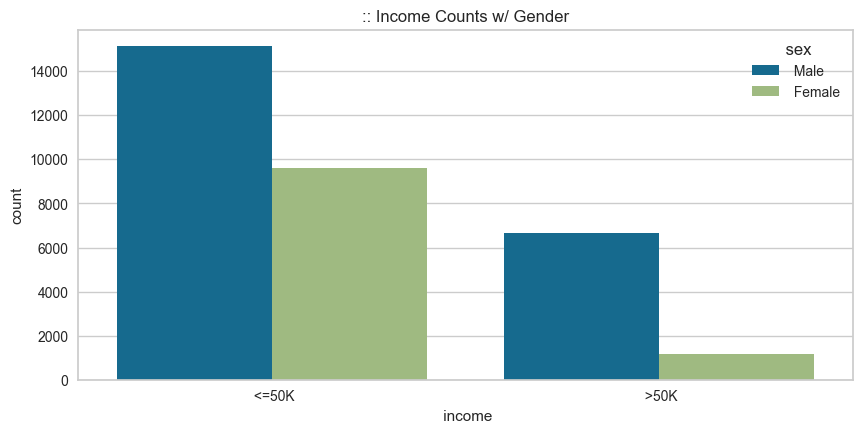

In [6]:
plt.figure(figsize=(10,10))
plt.subplot(2,1,1)
sns.countplot(x=' income',data=income_data,hue=' sex')
plt.title(":: Income Counts w/ Gender")

Here, we have 2 variables that has massive cardinatlity and we need a way to figure out the discretize them.  
Let's also cross check their influence against the Income target
1. marital-status
2. native-country

Text(0.5, 1.0, ':: Income Counts w/ Marital Status')

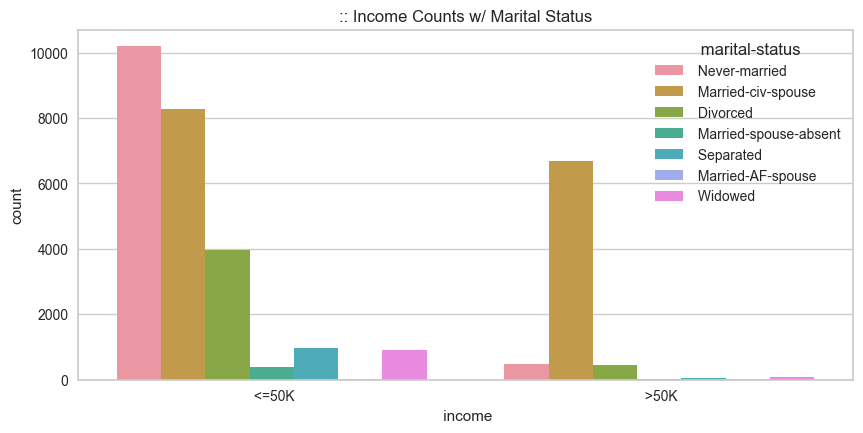

In [7]:
plt.figure(figsize=(10,10))
plt.subplot(2,1,1)
sns.countplot(x=' income',data=income_data,hue=' marital-status')
plt.title(":: Income Counts w/ Marital Status")

Solution :: Will merge all the married together as 'Married'

Text(0.5, 1.0, ':: Income Counts w/ Marital Status')

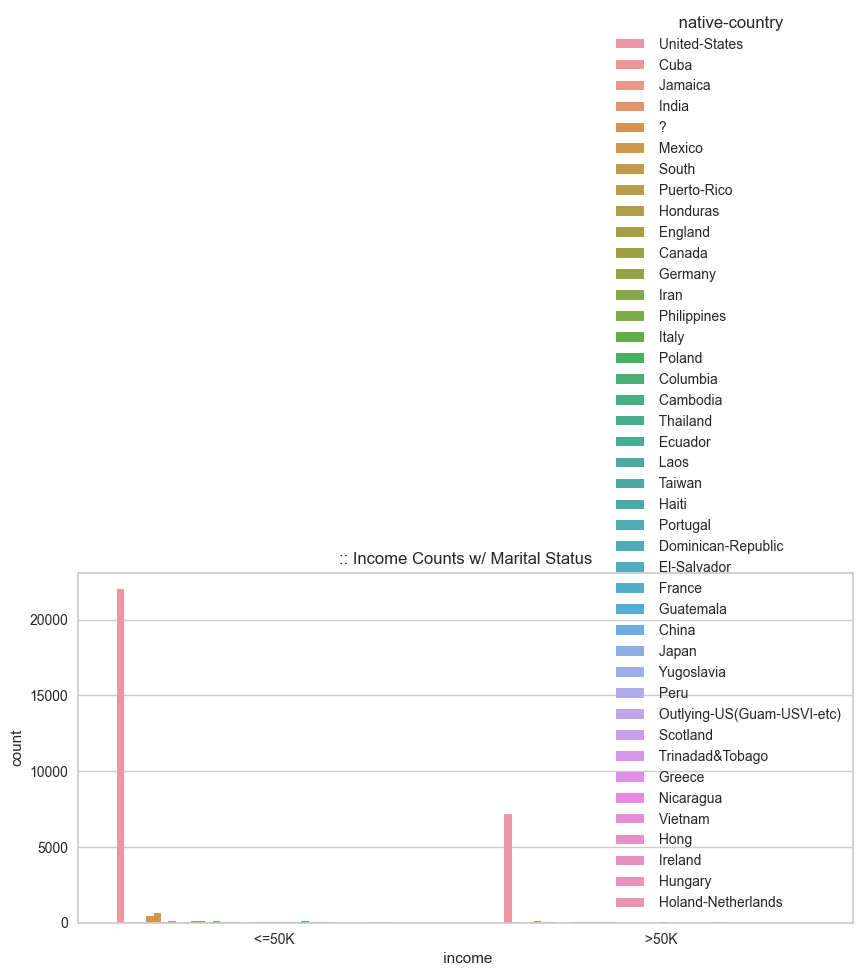

In [8]:
plt.figure(figsize=(10,10))
plt.subplot(2,1,1)
sns.countplot(x=' income',data=income_data,hue=' native-country')
plt.title(":: Income Counts w/ Marital Status")

Too many countries and extermely high cardinality

## Step-3 :: Feature Processing & Engineering

In [9]:
## Income based visualization
int_cols = income_data.select_dtypes(['int']).columns
cat_cols = list(set(income_data.columns) - set(int_cols))

#### Basic Cleanup

Here we cleanup the data such as converting all into lower, stripping any blank spaces

In [10]:
## Create a copy of the data brfore any cleanup or processing
income_data_cleaned = income_data.copy()

## Run a lower & a strip function on the categorical columns
income_data_cleaned[cat_cols] = income_data_cleaned[cat_cols].apply(lambda x:x.str.lower().str.strip())

income_data_cleaned.head(10)

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,state-gov,77516,bachelors,13,never-married,adm-clerical,not-in-family,white,male,2174,0,40,united-states,<=50k
1,50,self-emp-not-inc,83311,bachelors,13,married-civ-spouse,exec-managerial,husband,white,male,0,0,13,united-states,<=50k
2,38,private,215646,hs-grad,9,divorced,handlers-cleaners,not-in-family,white,male,0,0,40,united-states,<=50k
3,53,private,234721,11th,7,married-civ-spouse,handlers-cleaners,husband,black,male,0,0,40,united-states,<=50k
4,28,private,338409,bachelors,13,married-civ-spouse,prof-specialty,wife,black,female,0,0,40,cuba,<=50k
5,37,private,284582,masters,14,married-civ-spouse,exec-managerial,wife,white,female,0,0,40,united-states,<=50k
6,49,private,160187,9th,5,married-spouse-absent,other-service,not-in-family,black,female,0,0,16,jamaica,<=50k
7,52,self-emp-not-inc,209642,hs-grad,9,married-civ-spouse,exec-managerial,husband,white,male,0,0,45,united-states,>50k
8,31,private,45781,masters,14,never-married,prof-specialty,not-in-family,white,female,14084,0,50,united-states,>50k
9,42,private,159449,bachelors,13,married-civ-spouse,exec-managerial,husband,white,male,5178,0,40,united-states,>50k


Removing all the Null values, here the null values are not default NaN.  
Instead they are tagged as " ?" 

In [11]:
## Check the columns that have " ?"
# Find columns containing "?"
columns_with_question_mark = (income_data_cleaned == "?").any()

# Get the names of columns containing "?"
columns_with_question_mark = columns_with_question_mark[columns_with_question_mark].index.tolist()

# Print the columns containing "?"
print("Columns containing '?' :", columns_with_question_mark)
print("Dataset shape before '?' removal :",income_data_cleaned.shape)

# Filter out rows where any of the columns with "?" contain "?"
income_data_cleaned = income_data_cleaned[~income_data_cleaned[columns_with_question_mark].isin(["?"]).any(axis=1)]

# Reset index after dropping rows
income_data_cleaned.reset_index(drop=True, inplace=True)

print("Dataset shape after '?' removal :",income_data_cleaned.shape)

Columns containing '?' : [' workclass', ' occupation', ' native-country']
Dataset shape before '?' removal : (32561, 15)
Dataset shape after '?' removal : (30162, 15)


In [12]:
income_data_cleaned.head(10)

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,state-gov,77516,bachelors,13,never-married,adm-clerical,not-in-family,white,male,2174,0,40,united-states,<=50k
1,50,self-emp-not-inc,83311,bachelors,13,married-civ-spouse,exec-managerial,husband,white,male,0,0,13,united-states,<=50k
2,38,private,215646,hs-grad,9,divorced,handlers-cleaners,not-in-family,white,male,0,0,40,united-states,<=50k
3,53,private,234721,11th,7,married-civ-spouse,handlers-cleaners,husband,black,male,0,0,40,united-states,<=50k
4,28,private,338409,bachelors,13,married-civ-spouse,prof-specialty,wife,black,female,0,0,40,cuba,<=50k
5,37,private,284582,masters,14,married-civ-spouse,exec-managerial,wife,white,female,0,0,40,united-states,<=50k
6,49,private,160187,9th,5,married-spouse-absent,other-service,not-in-family,black,female,0,0,16,jamaica,<=50k
7,52,self-emp-not-inc,209642,hs-grad,9,married-civ-spouse,exec-managerial,husband,white,male,0,0,45,united-states,>50k
8,31,private,45781,masters,14,never-married,prof-specialty,not-in-family,white,female,14084,0,50,united-states,>50k
9,42,private,159449,bachelors,13,married-civ-spouse,exec-managerial,husband,white,male,5178,0,40,united-states,>50k


### Re-Sampling Martial-Status

In [13]:
income_data_cleaned[' marital-status'] = income_data_cleaned[' marital-status'].replace('never-married','unmarried')

income_data_cleaned[' marital-status'] = income_data_cleaned[' marital-status'].str.split('-').str[0]

income_data_cleaned.head(10)

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,state-gov,77516,bachelors,13,unmarried,adm-clerical,not-in-family,white,male,2174,0,40,united-states,<=50k
1,50,self-emp-not-inc,83311,bachelors,13,married,exec-managerial,husband,white,male,0,0,13,united-states,<=50k
2,38,private,215646,hs-grad,9,divorced,handlers-cleaners,not-in-family,white,male,0,0,40,united-states,<=50k
3,53,private,234721,11th,7,married,handlers-cleaners,husband,black,male,0,0,40,united-states,<=50k
4,28,private,338409,bachelors,13,married,prof-specialty,wife,black,female,0,0,40,cuba,<=50k
5,37,private,284582,masters,14,married,exec-managerial,wife,white,female,0,0,40,united-states,<=50k
6,49,private,160187,9th,5,married,other-service,not-in-family,black,female,0,0,16,jamaica,<=50k
7,52,self-emp-not-inc,209642,hs-grad,9,married,exec-managerial,husband,white,male,0,0,45,united-states,>50k
8,31,private,45781,masters,14,unmarried,prof-specialty,not-in-family,white,female,14084,0,50,united-states,>50k
9,42,private,159449,bachelors,13,married,exec-managerial,husband,white,male,5178,0,40,united-states,>50k


Text(0.5, 1.0, ':: Income Counts w/ Marital Status')

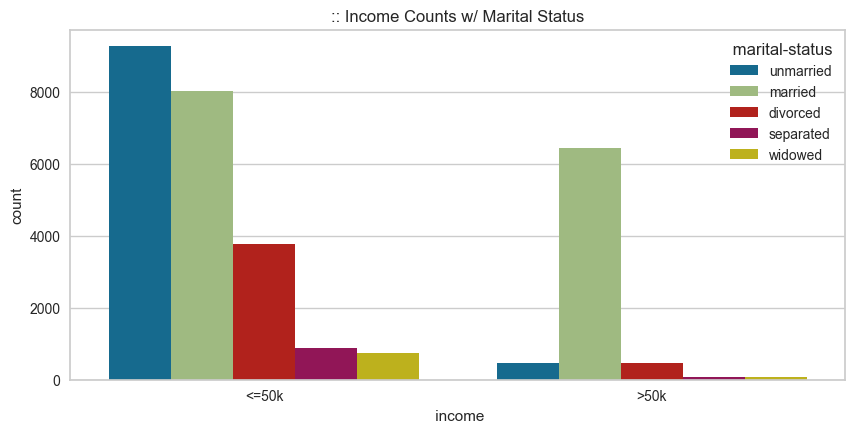

In [14]:
## Have a relook at the data
plt.figure(figsize=(10,10))
plt.subplot(2,1,1)
sns.countplot(x=' income',data=income_data_cleaned,hue=' marital-status')
plt.title(":: Income Counts w/ Marital Status")

In [15]:
## Encoding all the categorical columns
le = LabelEncoder()

cols_to_encode = [' race',
 ' workclass',
 ' sex',
 ' marital-status',
 ' relationship',
 ' education',
 ' native-country',
 ' occupation']

income_data_cleaned[cols_to_encode] = income_data_cleaned[cols_to_encode].apply(le.fit_transform)

In [16]:
income_data_cleaned.head(10)

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,5,77516,9,13,3,0,1,4,1,2174,0,40,38,<=50k
1,50,4,83311,9,13,1,3,0,4,1,0,0,13,38,<=50k
2,38,2,215646,11,9,0,5,1,4,1,0,0,40,38,<=50k
3,53,2,234721,1,7,1,5,0,2,1,0,0,40,38,<=50k
4,28,2,338409,9,13,1,9,5,2,0,0,0,40,4,<=50k
5,37,2,284582,12,14,1,3,5,4,0,0,0,40,38,<=50k
6,49,2,160187,6,5,1,7,1,2,0,0,0,16,22,<=50k
7,52,4,209642,11,9,1,3,0,4,1,0,0,45,38,>50k
8,31,2,45781,12,14,3,9,1,4,0,14084,0,50,38,>50k
9,42,2,159449,9,13,1,3,0,4,1,5178,0,40,38,>50k


## Step-4 :: Feature Selection

In [17]:
## Splitting the data into X & Y
X = income_data_cleaned.drop(columns=[' income'])
y = income_data_cleaned[' income']

### Correlation Assessment

<Axes: >

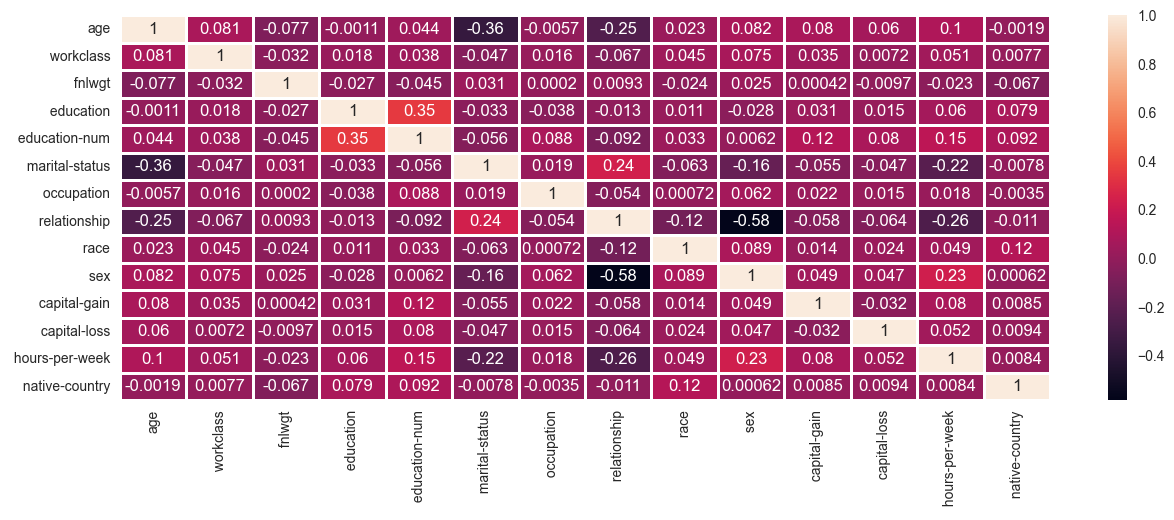

In [18]:
plt.figure(figsize=(15,5))
sns.heatmap(X.corr(), annot=True, linewidths=1)

1. Education & Education-Num has a high correlation value, indicating the are very similar  
2. Sex & relationship also have a strong negative correlation, indicating inversely similar

### Checking for Mutual Info Gain

In [19]:
# Calculate mutual information gain
mi_gain = mutual_info_classif(X, y)

# Create a DataFrame to display feature names and their mutual information gain
mi_gain_df = pd.DataFrame({'Feature': X.columns, 'MI_Gain': mi_gain})
mi_gain_df.sort_values(by='MI_Gain', ascending=False, inplace=True)

# Display the result
print(mi_gain_df)

            Feature   MI_Gain
7      relationship  0.118368
5    marital-status  0.108774
10     capital-gain  0.081546
4     education-num  0.066698
6        occupation  0.065528
0               age  0.065414
3         education  0.064162
12   hours-per-week  0.045203
11     capital-loss  0.032599
2            fnlwgt  0.029569
9               sex  0.027730
1         workclass  0.018231
8              race  0.010025
13   native-country  0.009208


### Checking for RFE

In [20]:
# Initialize a classifier (e.g., Random Forest)
clf = DecisionTreeClassifier()

# Initialize RFECV
rfecv = RFECV(estimator=clf, step=1, cv=StratifiedKFold(5), scoring='f1_weighted')

# Fit RFECV to the data
rfecv.fit(X, y)

# Print the optimal number of features
print("Optimal number of features : %d" % rfecv.n_features_)
print("Selected Features :: \n","\n".join([val for val in X.columns[rfecv.support_].to_list()]))

Optimal number of features : 11
Selected Features :: 
 age
 workclass
 fnlwgt
 education-num
 occupation
 relationship
 race
 capital-gain
 capital-loss
 hours-per-week
 native-country


Final List of Variables:  
[' relationship', ' marital-status', ' capital-gain', 'age', ' education-num', ' occupation', ' hours-per-week', ' fnlwgt']

## Step-5 :: Model Selection

Here we will use Automl Technique for the model selection and giving us with the most optimised model

In [29]:
## Final List of Variables
var_list = [' relationship', ' marital-status', ' capital-gain', 'age', ' education-num', ' occupation', ' hours-per-week', ' fnlwgt']
X = X[var_list]
y = y

In [30]:
## Splitting the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=0)

In [22]:
clf1 = setup(data = X_train, target = y_train, train_size=0.7, n_jobs=1)

# compare models
best = compare_models(n_select = 10, sort='F1')

,Description,Value
0,Session id,4424
1,Target,income
2,Target type,Binary
3,Target mapping,"<=50k: 0, >50k: 1"
4,Original data shape,"(21113, 15)"
5,Transformed data shape,"(21113, 15)"
6,Transformed train set shape,"(14779, 15)"
7,Transformed test set shape,"(6334, 15)"
8,Numeric features,14
9,Preprocess,True


KeyboardInterrupt: 

In [ ]:
print(best)

[LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=1, num_leaves=31, objective=None,
               random_state=4832, reg_alpha=0.0, reg_lambda=0.0, subsample=1.0,
               subsample_for_bin=200000, subsample_freq=0), GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='log_loss', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_samples_leaf=1,
                           min_samples_split=2, min_weight_fraction_leaf=0.0,
                           n_estimators=100, n_iter_no_change=None,
                           random_state=4832, subsample=1.0, tol=0.0001,
                           validation_

In [31]:
## Using the AutoML selected model for final building
lgbm = LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=1, num_leaves=31, objective=None,
               random_state=4832, reg_alpha=0.0, reg_lambda=0.0, subsample=1.0,
               subsample_for_bin=200000, subsample_freq=0)

## Fitting the model
lgbm.fit(X_train,y_train)

## Train predictions
train_preds = lgbm.predict(X_train)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 5223, number of negative: 15890
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000353 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 537
[LightGBM] [Info] Number of data points in the train set: 21113, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.247383 -> initscore=-1.112618
[LightGBM] [Info] Start training from score -1.112618


In [32]:
def evaluate(y_true,y_pred):
    print("Accuracy Score :: ",accuracy_score(y_true,y_pred))
    print("F1 Score :: ",f1_score(y_true,y_pred,average='weighted'))
    print("Recall Score :: ",recall_score(y_true,y_pred,average='weighted'))
    print("Precision Score :: ",precision_score(y_true,y_pred,average='weighted'))
    print("Classification Report :: \n",classification_report(y_true,y_pred))
    
## Train results
evaluate(y_train,train_preds)

Accuracy Score ::  0.8793160611945247
F1 Score ::  0.8760397430250101
Recall Score ::  0.8793160611945247
Precision Score ::  0.8756967820004992
Classification Report :: 
               precision    recall  f1-score   support

       <=50k       0.90      0.94      0.92     15890
        >50k       0.80      0.68      0.74      5223

    accuracy                           0.88     21113
   macro avg       0.85      0.81      0.83     21113
weighted avg       0.88      0.88      0.88     21113



In [33]:
test_preds = lgbm.predict(X_test)

evaluate(y_test,test_preds)

Accuracy Score ::  0.8572217924632556
F1 Score ::  0.8532866714632565
Recall Score ::  0.8572217924632556
Precision Score ::  0.852372234950941
Classification Report :: 
               precision    recall  f1-score   support

       <=50k       0.89      0.93      0.91      6764
        >50k       0.75      0.64      0.69      2285

    accuracy                           0.86      9049
   macro avg       0.82      0.79      0.80      9049
weighted avg       0.85      0.86      0.85      9049



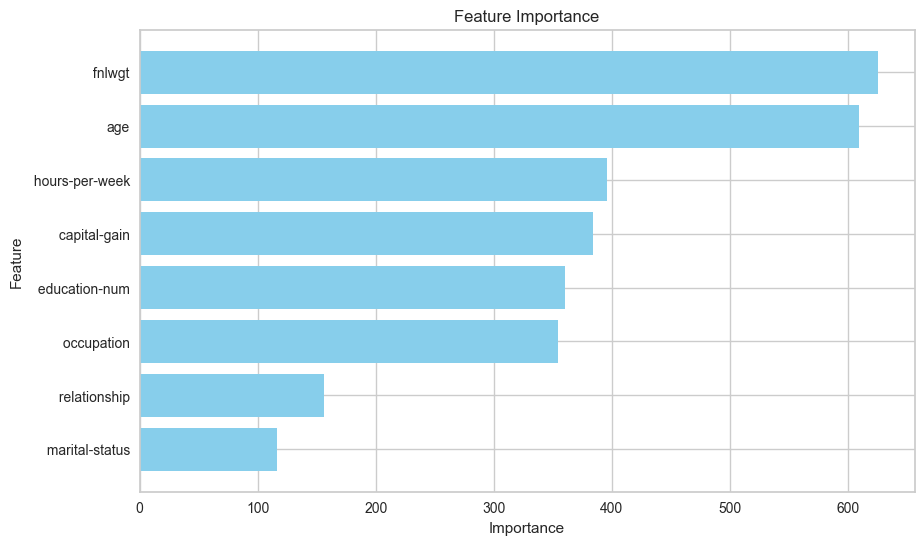

In [34]:
## Feature Importance Plot:
importances = lgbm.feature_importances_

feature_names = X.columns

feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})

feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=True)

plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance')
plt.show()